# EfficientNet

In [6]:
#import the required Libraries

import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [7]:
#Links to the image dataset and the metadata csv

img_link ='dataverse_files/HAM10000_images'
csv_link = 'dataverse_files/HAM10000_metadata.csv'

In [10]:
# load, resize and process images  and map the class labels from metadata

metadata = pd.read_csv(csv_link)
labels = metadata['dx']

images = []
for img_id in metadata['image_id']:
    img_path = os.path.join(img_link, img_id+'.jpg')
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    images.append(image)
X = np.array(images)
y = to_categorical(labels.factorize()[0], num_classes=7)

In [11]:
#split train and test data to 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
#Model architecture for EfficientNetB0 with correct input shape 
base_model = EfficientNetB0(include_top=False, input_shape=(128,128,3), weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

16705208/16705208 [==============================] - 4s 0us/step


In [15]:
#compile model and configure Early stopping
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [16]:
#fit and train model for 50 epochs
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

model.save('efficientNet.h5')

Epoch 1/50
251/251 [==============================] - 95s 363ms/step - loss: 0.9131 - accuracy: 0.6986 - val_loss: 0.7191 - val_accuracy: 0.7359
Epoch 2/50
251/251 [==============================] - 91s 363ms/step - loss: 0.6877 - accuracy: 0.7542 - val_loss: 0.6850 - val_accuracy: 0.7569
Epoch 3/50
251/251 [==============================] - 92s 366ms/step - loss: 0.6021 - accuracy: 0.7846 - val_loss: 0.6715 - val_accuracy: 0.7559
Epoch 4/50
251/251 [==============================] - 93s 371ms/step - loss: 0.5494 - accuracy: 0.8050 - val_loss: 0.6744 - val_accuracy: 0.7604
Epoch 5/50
251/251 [==============================] - 93s 371ms/step - loss: 0.4943 - accuracy: 0.8216 - val_loss: 0.6607 - val_accuracy: 0.7629
Epoch 6/50
251/251 [==============================] - 93s 370ms/step - loss: 0.4497 - accuracy: 0.8411 - val_loss: 0.6443 - val_accuracy: 0.7708
Epoch 7/50
251/251 [==============================] - 93s 369ms/step - loss: 0.4093 - accuracy: 0.8541 - val_loss: 0.6511 - val_ac

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [17]:
#calculate accuracy, F-1 score, Precision, Recall and confusion Matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
confusion_mat = confusion_matrix(y_true, y_pred)
print('Test accuracy:', accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('Confusion matrix:', confusion_mat)

63/63 [==============================] - 18s 266ms/step
Test accuracy: 0.7973040342330933
F1 score: 0.7847114086605549
Precision: 0.7819545495434883
Recall: 0.7973040439340988
Confusion matrix: [[ 122   64    0   23    0   11    8]
 [  23 1270    0   34    2    7    2]
 [   3    9    8    3    0    3    2]
 [  30   88    0  100    0    3    5]
 [   1    7    0    0   13    0    0]
 [  12   14    1    4    0   57    5]
 [  14   13    1    6    1    7   27]]


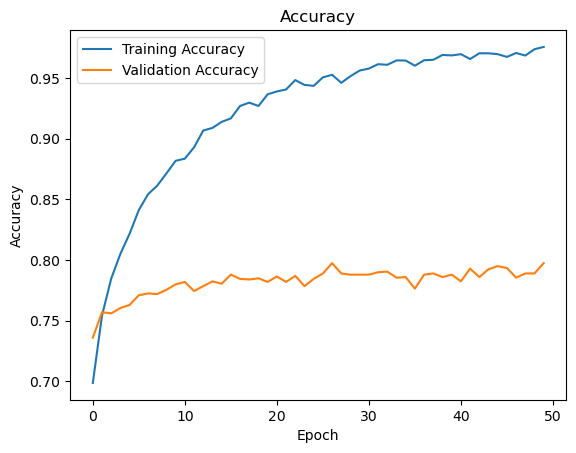

In [18]:
#Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

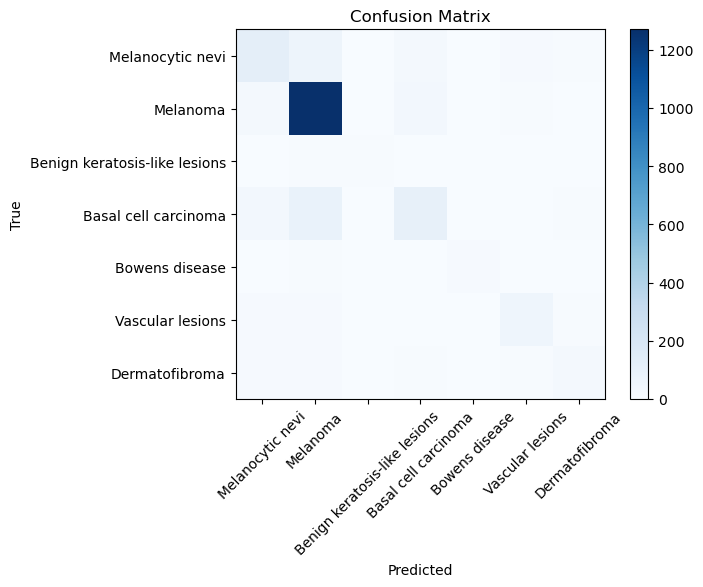

In [21]:
#plot confusion matrix

plt.imshow(confusion_mat, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

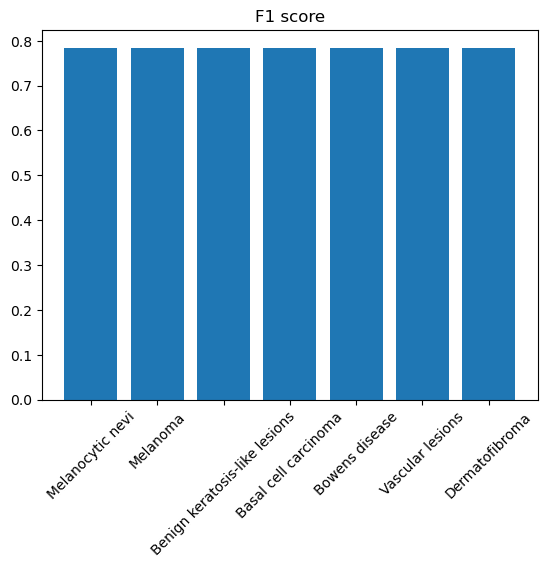

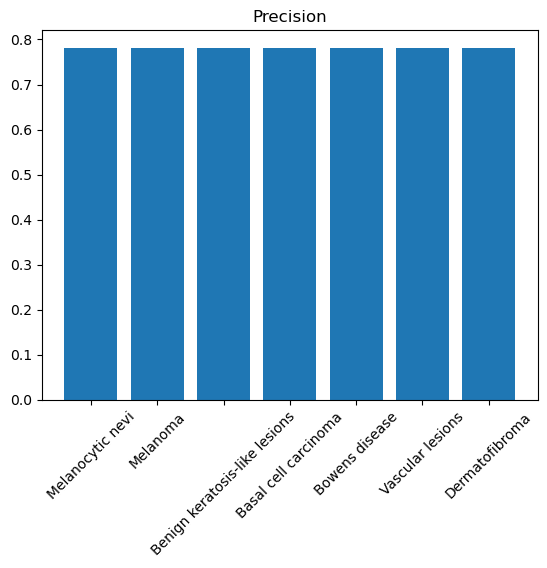

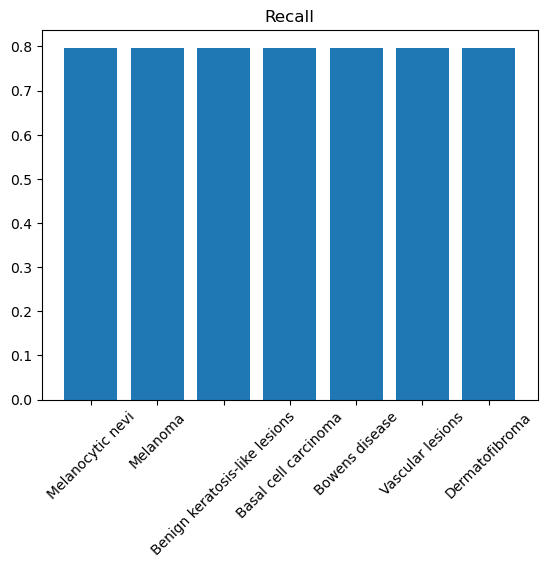

In [20]:
# Plot F1 score, precision, and recall

labels = ['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions', 'Basal cell carcinoma', 'Bowens disease', 'Vascular lesions', 'Dermatofibroma']
metrics = [f1, precision, recall]
metric_names = ['F1 score', 'Precision', 'Recall']
for i, metric in enumerate(metrics):
    plt.bar(labels, metric)
    plt.title(metric_names[i])
    plt.xticks(rotation=45)
    plt.show()

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9053252935409546
Test accuracy: 0.7973040342330933
